In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Read the dataset


In [2]:
file_path = "../Data/features_3_sec.csv"
data = pd.read_csv(file_path)
data.drop(labels="filename", axis=1, inplace=True)

In [3]:
X = data.iloc[:, :-1].values
y = data["label"].values

In [4]:
# Transforming the labels to numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

## Split the dataset into training and testing sets


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

## Define pipeline to build a model


In [6]:
def build_pipeline(model_name, model):
    print(f"Training {model_name} model")
    pipeline = Pipeline([("scaler", StandardScaler()), ("model", model)])
    return (model_name, pipeline)

## Define the model


In [7]:
models = {
    "Logistic": LogisticRegression(max_iter=1000, multi_class="multinomial"),
    "SVC": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

## Train the model


In [8]:
results = []
names = []
for i in range(len(models)):
    model_name, model = models.popitem()
    model_name, model = build_pipeline(model_name, model)
    cv_results = cross_val_score(
        model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring="accuracy"
    )
    results.append(cv_results)
    names.append(model_name)
    print(f"Model: {model_name}")
    print(f"Mean accuracy: {np.mean(cv_results)}")
    print(f"Std deviation: {np.std(cv_results)}")
    print()

Training XGBoost model
Model: XGBoost
Mean accuracy: 0.8941444942513351
Std deviation: 0.005999984734518084

Training Random Forest model
Model: Random Forest
Mean accuracy: 0.854104215635398
Std deviation: 0.003609574657666492

Training Decision Tree model
Model: Decision Tree
Mean accuracy: 0.6277520916154574
Std deviation: 0.007454100963263648

Training SVC model
Model: SVC
Mean accuracy: 0.8449684995550255
Std deviation: 0.00720081799489399

Training Logistic model
Model: Logistic
Mean accuracy: 0.7203442232747157
Std deviation: 0.009356116696873765



## Evaluate the model


In [9]:
# Comparing the models
fig = go.Figure()

for x, y in zip(results, names):
    fig.add_trace(go.Box(x=x, name=y))
fig.show()
fig.write_image("../report/graphics/baseline_models.jpg", scale=5)

## model evaluation


In [10]:
# evaluating the xgboost model

model = build_pipeline("XGBoost", XGBClassifier())[1]
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Training XGBoost model
              precision    recall  f1-score   support

       blues       0.88      0.90      0.89       200
   classical       0.92      0.96      0.94       199
     country       0.84      0.87      0.86       199
       disco       0.88      0.92      0.90       200
      hiphop       0.92      0.91      0.91       200
        jazz       0.89      0.90      0.89       200
       metal       0.95      0.94      0.94       200
         pop       0.95      0.87      0.91       200
      reggae       0.88      0.90      0.89       200
        rock       0.89      0.83      0.86       200

    accuracy                           0.90      1998
   macro avg       0.90      0.90      0.90      1998
weighted avg       0.90      0.90      0.90      1998

[[179   1   5   1   1   4   3   0   4   2]
 [  0 192   1   0   0   5   0   1   0   0]
 [  7   1 174   1   1   6   0   2   4   3]
 [  3   1   3 183   0   1   3   1   3   2]
 [  0   0   3   3 182   2   3   2   5   0]
 [ 

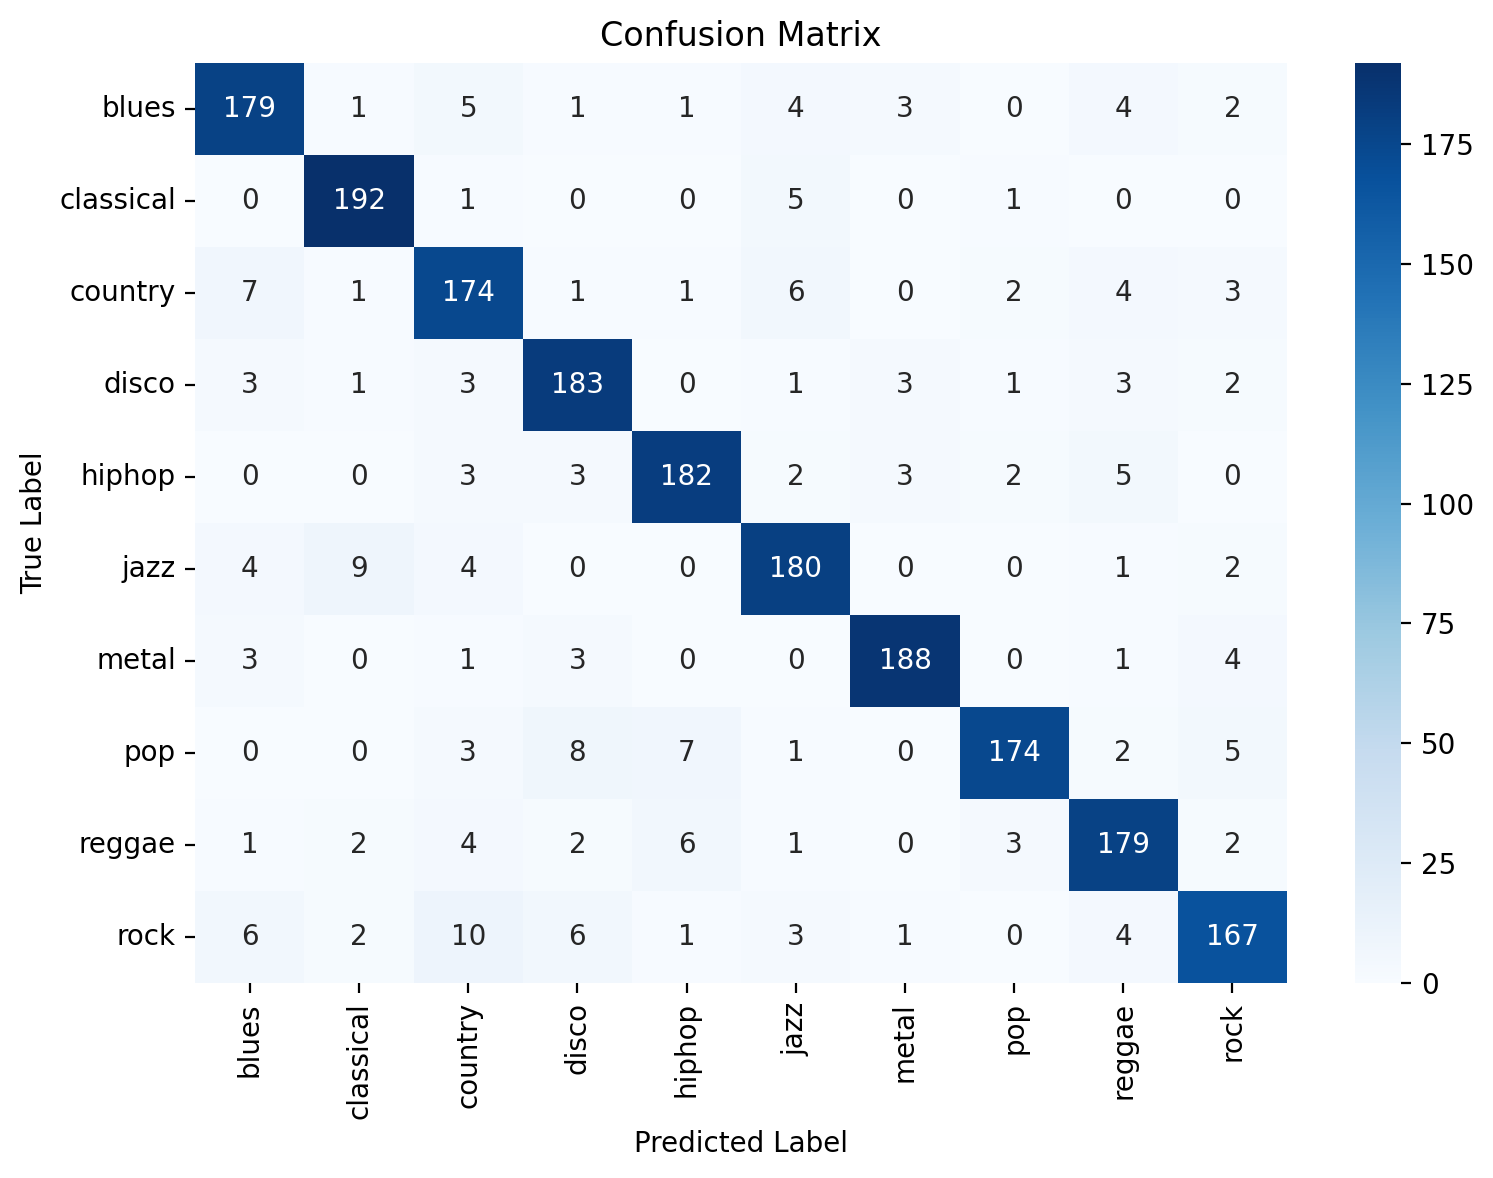

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("../report/graphics/confusion_matrix.pdf")
plt.show()

## Hyperparameter tuning


In [12]:
param_grid_xgb = {
    "n_estimators": [50, 100, 200, 500],  # Number of boosting rounds
    "learning_rate": [0.01, 0.1, 0.2, 0.3],  # Step size shrinkage
    "max_depth": [3, 5, 7, 10],  # Maximum depth of trees
    "subsample": [0.6, 0.8, 1.0],  # Fraction of samples per boosting round
    "colsample_bytree": [0.6, 0.8, 1.0],  # Fraction of features for each tree
    "gamma": [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required for a split
    "reg_alpha": [0, 0.1, 0.5, 1],  # L1 regularization
    "reg_lambda": [0, 0.1, 0.5, 1],  # L2 regularization
}
model = XGBClassifier()
randomcv = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid_xgb,
    n_iter=100,
    cv=3,
    verbose=2,
    n_jobs=-1,
)
randomcv.fit(X_train, y_train)
randomcv.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.3, max_depth=7, n_estimators=50, reg_alpha=0.1, reg_lambda=0.5, subsample=0.6; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   6.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   6.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   6.2

{'subsample': 0.6,
 'reg_lambda': 0,
 'reg_alpha': 0.5,
 'n_estimators': 500,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0,
 'colsample_bytree': 0.8}

In [13]:
# evaluating the xgboost model with the best parameters
model = build_pipeline(
    "XGBoost",
    XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.2,
        gamma=0,
        colsample_bytree=0.8,
        reg_alpha=0,
        reg_lambda=1,
        subsample=0.8,
    ),
)[1]
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Training XGBoost model
              precision    recall  f1-score   support

       blues       0.89      0.92      0.90       200
   classical       0.92      0.97      0.95       199
     country       0.87      0.86      0.87       199
       disco       0.87      0.92      0.90       200
      hiphop       0.92      0.92      0.92       200
        jazz       0.90      0.91      0.90       200
       metal       0.95      0.96      0.96       200
         pop       0.94      0.84      0.89       200
      reggae       0.90      0.92      0.91       200
        rock       0.91      0.84      0.88       200

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998

[[183   2   2   2   1   2   2   0   4   2]
 [  0 194   0   0   0   4   0   1   0   0]
 [  7   1 172   2   1   5   1   2   4   4]
 [  1   1   5 184   2   0   3   1   2   1]
 [  0   0   1   3 184   2   3   4   3   0]
 [ 

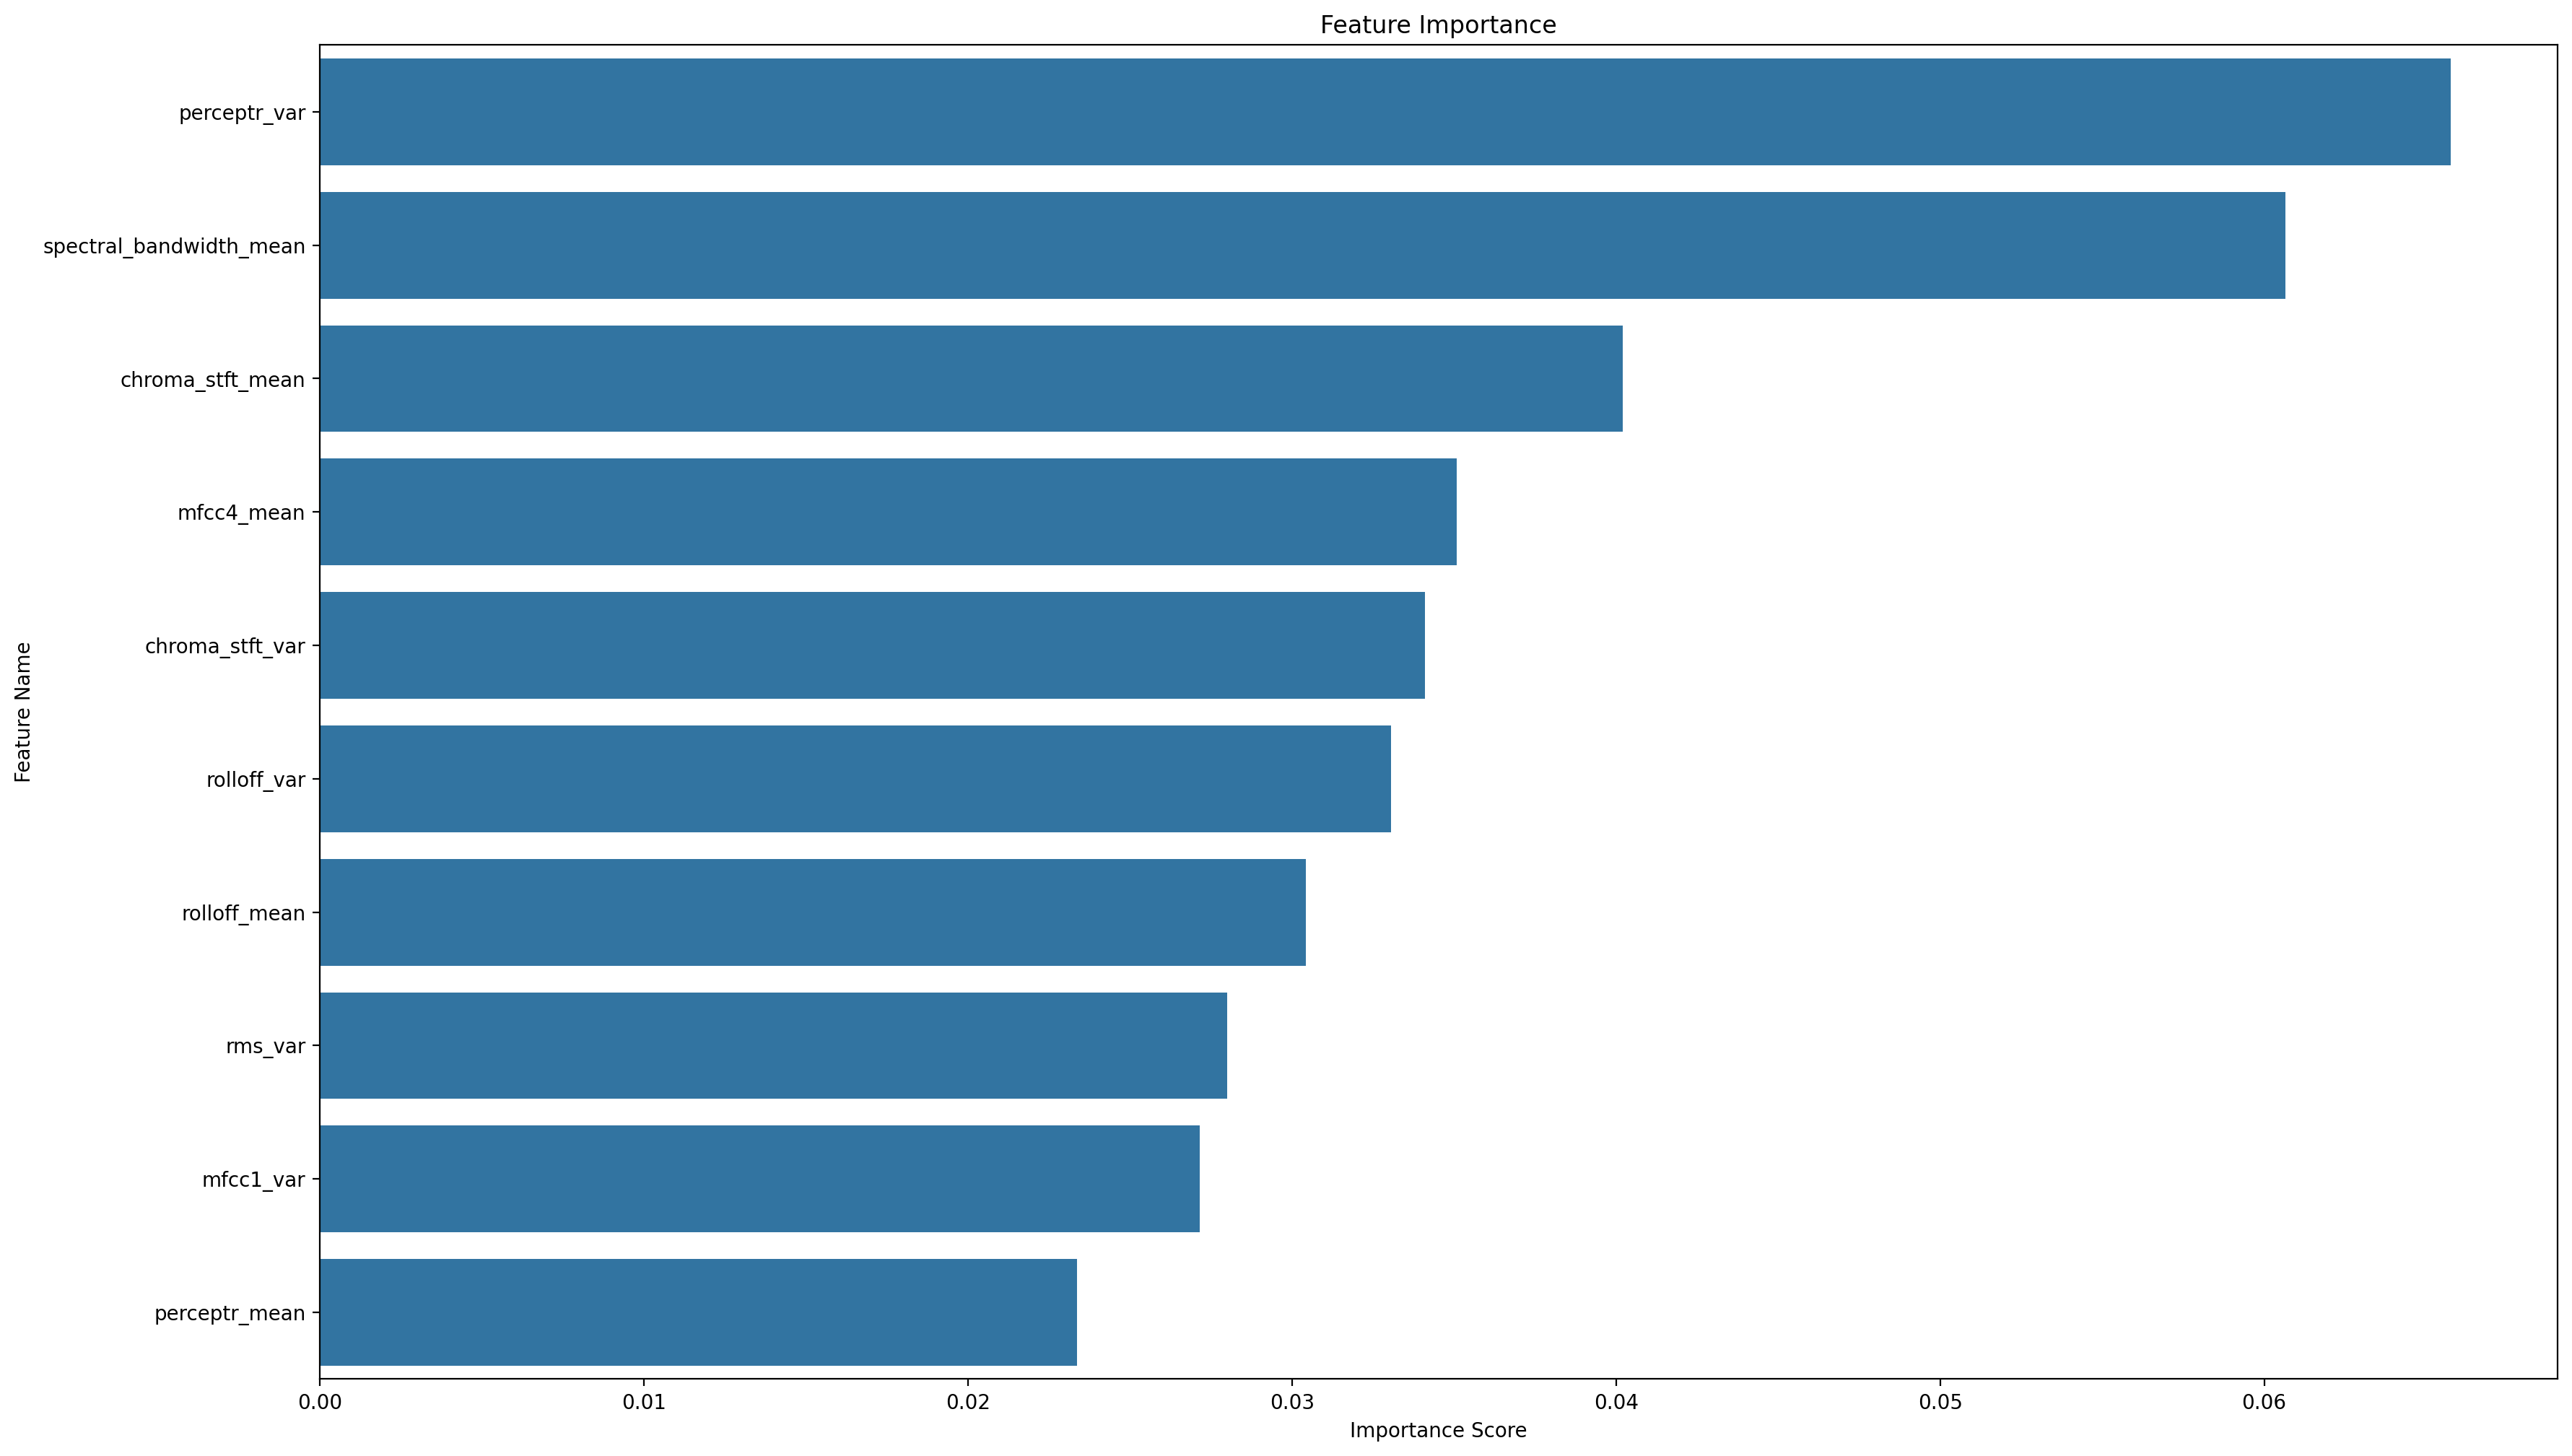

In [25]:
# print the importance of each feature

xgb_model = model.named_steps["model"]
# Get feature importance scores
importance = xgb_model.feature_importances_


# Get feature names
feature_names = data.columns[:-1]
# Convert to DataFrame
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importance})

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

importance_df = importance_df.head(10)

# Plot with correct y-axis labels
plt.figure(figsize=(20, 12))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Feature Importance")
plt.savefig("../report/graphics/feature_importance.pdf")
plt.show()

In [ ]:
# Evaluate SVM model
model = build_pipeline("SVM", SVC())[1]
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Training SVM model
              precision    recall  f1-score   support

       blues       0.83      0.85      0.84       200
   classical       0.86      0.96      0.91       199
     country       0.83      0.81      0.82       199
       disco       0.77      0.81      0.79       200
      hiphop       0.90      0.81      0.86       200
        jazz       0.85      0.88      0.87       200
       metal       0.92      0.92      0.92       200
         pop       0.90      0.81      0.86       200
      reggae       0.83      0.86      0.85       200
        rock       0.78      0.73      0.76       200

    accuracy                           0.85      1998
   macro avg       0.85      0.85      0.85      1998
weighted avg       0.85      0.85      0.85      1998

[[170   3   4   3   2   7   6   0   2   3]
 [  0 191   1   0   0   4   0   0   0   3]
 [ 11   2 161   1   0   5   1   5   3  10]
 [  0   2   1 162   3   2   7   3   6  14]
 [  1   4   3   6 163   0   2   8  13   0]
 [  6  

In [ ]:
# Evaluate Random Forest model
model = build_pipeline("Random Forest", RandomForestClassifier())[1]
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Training Random Forest model
              precision    recall  f1-score   support

       blues       0.85      0.87      0.86       200
   classical       0.91      0.97      0.94       199
     country       0.81      0.82      0.82       199
       disco       0.81      0.84      0.83       200
      hiphop       0.92      0.86      0.89       200
        jazz       0.86      0.91      0.89       200
       metal       0.88      0.94      0.91       200
         pop       0.95      0.83      0.89       200
      reggae       0.83      0.86      0.85       200
        rock       0.86      0.76      0.81       200

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      0.87      1998

[[174   1   6   3   0   4   6   0   5   1]
 [  0 193   1   0   0   4   0   0   0   1]
 [  9   3 164   3   0   7   1   3   6   3]
 [  2   1   6 169   1   1   7   0   7   6]
 [  1   1   2   6 172   1   4   4   7   